In [1]:
import setGPU

setGPU: Setting GPU to: 3


In [2]:
random_state=999

# Load data

In [3]:
from secml.data.loader import CDataLoaderMNIST
loader = CDataLoaderMNIST()
tr = loader.load('training')
ts = loader.load('testing')

# Normalize the data
tr.X /= 255
ts.X /= 255

/home/crecchi/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
tr.X.shape, ts.X.shape

((60000, 784), (10000, 784))

Split data into train-validation set (Stacked Generalization alike)

In [5]:
from secml.data.splitter import CTrainTestSplit

In [6]:
tr, vl = CTrainTestSplit(test_size=0.5, random_state=random_state).split(tr)

In [7]:
tr.X.shape[0], vl.X.shape[0]

(30000, 30000)

# NN classifier

In [8]:
import torch
from torch import nn, optim

In [9]:
class Flatten(nn.Module):
    """Layer custom per reshape del tensore
    """
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return x

In [10]:
import torch
from torch import nn

class MNISTCNN(nn.Module):
    """Model with input size (-1, 28, 28) for MNIST 3-classes dataset."""
    def __init__(self):
        super(MNISTCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3)
        self.flat = Flatten()
        self.fc1 = nn.Linear(1024, 200)
        self.fc2 = nn.Linear(200, 200)
        self.fc3 = nn.Linear(200, 10)

    def forward(self, x):
        # 1st block
        x = torch.relu(self.conv1(x))
        x = torch.relu(torch.max_pool2d(self.conv2(x), 2))
        # 2nd block
        x = torch.relu(self.conv3(x))
        x = torch.relu(torch.max_pool2d(self.conv4(x), 2))
        # Flatten
        x = self.flat(x)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [11]:
# import numpy as np
# import torch.autograd as autograd

# def compute_out_size(in_size, mod):
#     """
#     Compute output size of Module `mod` given an input with size `in_size`.
#     """
    
#     f = mod.forward(autograd.Variable(torch.Tensor(1, *in_size)))
#     return int(np.prod(f.size()[1:]))

In [12]:
net = MNISTCNN()
# x = torch.Tensor(1, 28, 28) # shape = (batch size, channels, height, width)
# print(compute_out_size(x.size(), net))

In [13]:
!conda list | grep summary

torchsummary              1.5.1                    pypi_0    pypi


In [14]:
from torchsummary import summary

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = net.to(device)
summary(net, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 32, 24, 24]           9,248
            Conv2d-3           [-1, 64, 10, 10]          18,496
            Conv2d-4             [-1, 64, 8, 8]          36,928
           Flatten-5                 [-1, 1024]               0
            Linear-6                  [-1, 200]         205,000
            Linear-7                  [-1, 200]          40,200
            Linear-8                   [-1, 10]           2,010
Total params: 312,202
Trainable params: 312,202
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.40
Params size (MB): 1.19
Estimated Total Size (MB): 1.59
----------------------------------------------------------------


### Wrap it

In [16]:
from torch import optim

# Random seed
torch.manual_seed(0)

net = MNISTCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),
                      lr=0.01, momentum=0.9)

from secml.ml.classifiers import CClassifierPyTorch
dnn = CClassifierPyTorch(model=net,
                         loss=criterion,
                         optimizer=optimizer,
                         epochs=25,
                         batch_size=128,
                         input_shape=(1, 28, 28),
                         random_state=0)

In [17]:
dnn.verbose = 0  # Can be used to display training process output

In [18]:
print("Training started...")
dnn.fit(tr)
print("Training completed!")

Training started...
Training completed!


In [19]:
print(dnn)

CClassifierPyTorch{'classes': CArray(10,)(dense: [0 1 2 3 4 5 6 7 8 9]), 'n_features': 784, 'preprocess': None, 'model': MNISTCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (flat): Flatten()
  (fc1): Linear(in_features=1024, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=10, bias=True)
), 'trained': True, 'input_shape': (1, 28, 28), 'softmax_outputs': False, 'batch_size': 128, 'loss': CrossEntropyLoss(), 'optimizer': SGD (
Parameter Group 0
    dampening: 0
    lr: 0.01
    momentum: 0.9
    nesterov: False
    weight_decay: 0
), 'optimizer_scheduler': None, 'epochs': 25}


In [20]:
label_torch = dnn.predict(ts.X, return_decision_function=False)

from secml.ml.peval.metrics import CMetric
acc_torch = CMetric.create('accuracy').performance_score(ts.Y, label_torch)

print("Model Accuracy: {}".format(acc_torch))

Model Accuracy: 0.9885


---

# Generate Adversarial Samples

In [21]:
# For simplicity, let's attack a subset of the test set
attack_ds = ts[:100, :]

noise_type = 'l2'  # Type of perturbation 'l1' or 'l2'
dmax = 3.0  # Maximum perturbation
lb, ub = 0., 1.  # Bounds of the attack space. Can be set to `None` for unbounded
y_target = None  # None if `error-generic` or a class label for `error-specific`

# Should be chosen depending on the optimization problem
solver_params = {
    'eta': 0.5,
    'eta_min': 2.0,
    'eta_max': None,
    'max_iter': 100,
    'eps': 1e-6
}

from secml.adv.attacks import CAttackEvasionPGDLS
pgd_ls_attack = CAttackEvasionPGDLS(classifier=dnn,
                                    surrogate_classifier=dnn,
                                    surrogate_data=tr,
                                    distance=noise_type,
                                    dmax=dmax,
                                    solver_params=solver_params,
                                    y_target=y_target)

print("Attack started...")
eva_y_pred, _, eva_adv_ds, _ = pgd_ls_attack.run(
    attack_ds.X, attack_ds.Y, double_init=True)
print("Attack complete!")

Attack started...
Attack complete!


In [22]:
attack_ds.X.shape

(100, 784)

In [23]:
from secml.ml.peval.metrics import CMetric
metric = CMetric.create('accuracy')

acc = metric.performance_score(
    y_true=attack_ds.Y, y_pred=dnn.predict(attack_ds.X))
acc_attack = metric.performance_score(
    y_true=attack_ds.Y, y_pred=eva_y_pred)

print("Accuracy on reduced test set before attack: {:.2%}".format(acc))
print("Accuracy on reduced test set after attack: {:.2%}".format(acc_attack))

Accuracy on reduced test set before attack: 100.00%
Accuracy on reduced test set after attack: 7.00%


---

## Attack debug plots

In [24]:
dbg = loader.load('testing', digits=(4,9))
dbg.X /= 255.

In [25]:
x0, y0 = dbg[0, :].X, dbg[0, :].Y
x0, y0

(CArray(1, 784)(dense: [[0. 0. 0. ... 0. 0. 0.]]), CArray(1,)(dense: [0]))

In [26]:
noise_type = 'l2'  # Type of perturbation 'l1' or 'l2'
dmax = 3.0  # Maximum perturbation
lb, ub = 0., 1.  # Bounds of the attack space. Can be set to `None` for unbounded
y_target = 9 # CHANGED HERE FOR A TARGETED ATTACK! None if `error-generic` or a class label for `error-specific`

# Should be chosen depending on the optimization problem
solver_params = {
    'eta': 0.5,
    'eta_min': 2.0,
    'eta_max': None,
    'max_iter': 100,
    'eps': 1e-6
}

from secml.adv.attacks import CAttackEvasionPGDLS
pgd_ls_attack = CAttackEvasionPGDLS(classifier=dnn,
                                    surrogate_classifier=dnn,
                                    surrogate_data=tr,
                                    distance=noise_type,
                                    dmax=dmax,
                                    solver_params=solver_params,
                                    y_target=y_target)

In [27]:
eva_y_pred, _, eva_adv_ds, _ = pgd_ls_attack.run(x0, y0, double_init=True)

In [28]:
eva_y_pred 

CArray(1,)(dense: [9])

Visualize adversarial sample

In [29]:
from secml.figure import CFigure
# Only required for visualization in notebooks
%matplotlib inline

# Let's define a convenience function to easily plot the MNIST dataset
def show_digits(samples, preds, labels, digs, n_display=8):
    samples = samples.atleast_2d()
    n_display = min(n_display, samples.shape[0])
    fig = CFigure(width=n_display*2, height=3)
    for idx in range(n_display):
        fig.subplot(2, n_display, idx+1)
        fig.sp.xticks([])
        fig.sp.yticks([])
        fig.sp.imshow(samples[idx, :].reshape((28, 28)), cmap='gray')
        fig.sp.title("{} ({})".format(digits[labels[idx].item()], digs[preds[idx].item()]),
                     color=("green" if labels[idx].item()==preds[idx].item() else "red"))
    fig.show()

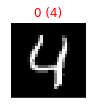

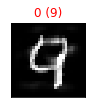

In [30]:
digits = tuple(range(10))
show_digits(x0, dnn.predict(x0), y0, digits)
show_digits(eva_adv_ds.X, dnn.predict(eva_adv_ds.X), eva_adv_ds.Y, digits)

In [31]:
pgd_ls_attack.f_seq

CArray(12,)(dense: [ 20.65148   12.901711   3.870911  -4.484192 -11.12654  -16.074574 -19.669788 -22.846813 -23.001904 -23.906122 -26.050974 -26.050974])

Plotting attack loss function:

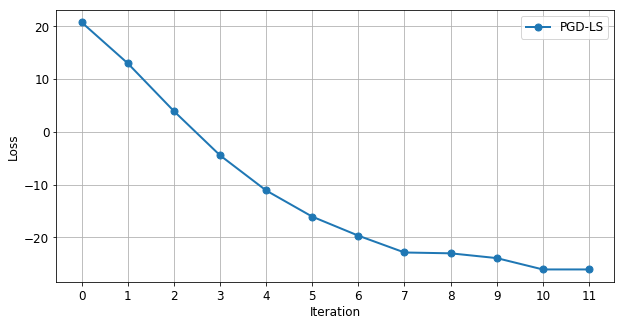

In [32]:
from secml.figure import CFigure
fig = CFigure(height=5, width=10)

# Convenience function for plotting the Security Evaluation Curve
fig.sp.plot(pgd_ls_attack._f_seq, marker='o', label='PGD-LS')
fig.sp.grid()
fig.sp.xticks(range(pgd_ls_attack._f_seq.shape[0]))
fig.sp.xlabel('Iteration')
fig.sp.ylabel('Loss')
fig.sp.legend()

Plotting classifier confidence during attack:

In [33]:
pgd_ls_attack.x_seq

CArray(12, 784)(dense: [[0.000000e+00 0.000000e+00 0.000000e+00 ... 0.000000e+00 0.000000e+00  0.000000e+00] [1.749372e-05 5.551279e-05 1.236473e-04 ... 0.000000e+00 0.000000e+00  0.000000e+00] [1.749372e-05 6.766292e-05 1.544083e-04 ... 1.070895e-07 0.000000e+00  0.000000e+00] ... [1.749372e-05 8.517079e-05 1.901542e-04 ... 0.000000e+00 2.391171e-06  0.000000e+00] [1.749372e-05 8.076923e-05 1.836870e-04 ... 0.000000e+00 6.347594e-07  0.000000e+00] [1.749372e-05 8.076923e-05 1.836870e-04 ... 0.000000e+00 6.347594e-07  0.000000e+00]])

In [34]:
four_score, nine_score = [], []

for i in range(pgd_ls_attack.x_seq.shape[0]):
    s = dnn.decision_function(pgd_ls_attack.x_seq[i,:])
    four_score.append(s[4].item())
    nine_score.append(s[9].item())

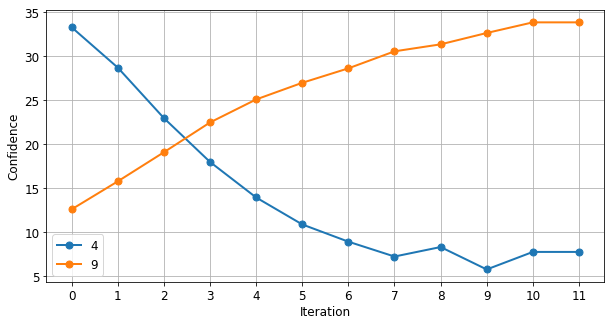

In [35]:
from secml.figure import CFigure
fig = CFigure(height=5, width=10)

# Convenience function for plotting the Security Evaluation Curve
fig.sp.plot(four_score, marker='o', label='4')
fig.sp.plot(nine_score, marker='o', label='9')
fig.sp.grid()
fig.sp.xticks(range(pgd_ls_attack.x_seq.shape[0]))
fig.sp.xlabel('Iteration')
fig.sp.ylabel('Confidence')
fig.sp.legend()

---

# Security evaluation of a classifier

In [36]:
# For simplicity, let's attack a subset of the test set
attack_ds = ts[:100, :]

noise_type = 'l2'  # Type of perturbation 'l1' or 'l2'
dmax = 3.0  # Maximum perturbation
lb, ub = 0., 1.  # Bounds of the attack space. Can be set to `None` for unbounded
y_target = None  # None if `error-generic` or a class label for `error-specific`

# Should be chosen depending on the optimization problem
solver_params = {
    'eta': 0.5,
    'eta_min': 2.0,
    'eta_max': None,
    'max_iter': 100,
    'eps': 1e-6
}

from secml.adv.attacks import CAttackEvasionPGDLS
pgd_ls_attack = CAttackEvasionPGDLS(classifier=dnn,
                                    surrogate_classifier=dnn,
                                    surrogate_data=tr,
                                    distance=noise_type,
                                    dmax=dmax,
                                    solver_params=solver_params,
                                    y_target=y_target)

In [37]:
# Perturbation levels to test
from secml.array import CArray
e_vals = CArray.arange(start=0, step=0.5, stop=5.1)

from secml.adv.seceval import CSecEval
sec_eval = CSecEval(
    attack=pgd_ls_attack, param_name='dmax', param_values=e_vals)

# Run the security evaluation using the test set
print("Running security evaluation...")
sec_eval.run_sec_eval(attack_ds, double_init=False)

Running security evaluation...


In [38]:
# Only required for visualization in notebooks
%matplotlib inline

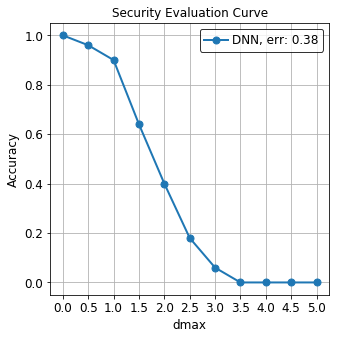

In [39]:
from secml.figure import CFigure
fig = CFigure(height=5, width=5)

# Convenience function for plotting the Security Evaluation Curve
fig.sp.plot_sec_eval(
    sec_eval.sec_eval_data, marker='o', label='DNN', show_average=True)

---

# Build detector

In [40]:
from secml.ml.features import CNormalizerDNN, CNormalizerMinMax

In [178]:
feat_extr = CNormalizerDNN(dnn, out_layer='flat')
nmz = CNormalizerMinMax(preprocess=feat_extr)

In [179]:
# Creation of the multiclass classifier
from secml.ml.classifiers import CClassifierSVM
from secml.ml.classifiers.multiclass import CClassifierMulticlassOVA
from secml.ml.kernels import CKernelRBF
clf = CClassifierMulticlassOVA(CClassifierSVM, kernel=CKernelRBF(), preprocess=nmz)

In [180]:
clf

CClassifierMulticlassOVA{'classes': None, 'n_features': None, 'preprocess': CNormalizerMinMax{'feature_range': (0.0, 1.0), 'min': None, 'max': None, 'm': None, 'q': None, 'preprocess': CNormalizerDNN{'net': CClassifierPyTorch{'classes': CArray(10,)(dense: [0 1 2 3 4 5 6 7 8 9]), 'n_features': 784, 'preprocess': None, 'model': MNISTCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (flat): Flatten()
  (fc1): Linear(in_features=1024, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=10, bias=True)
), 'trained': True, 'input_shape': (1, 28, 28), 'softmax_outputs': False, 'batch_size': 128, 'loss': CrossEntropyLoss(), 'optimizer': SGD (
Parameter Group 0
    dampening: 0
    lr: 0.01
    momentum: 0.9
    nes

In [121]:
# Parameters for the Cross-Validation procedure
xval_params = {'C': [1e-2, 1e-1, 1, 100],
               'kernel.gamma': [0.01, 0.1, 1, 10, 100]}

# Let's create a 3-Fold data splitter
from secml.data.splitter import CDataSplitterKFold
xval_splitter = CDataSplitterKFold(num_folds=3, random_state=random_state)

# Select and set the best training parameters for the classifier
clf.verbose = 1
print("Estimating the best training parameters...")
best_params = clf.estimate_parameters(
    dataset=vl,
    parameters=xval_params,
    splitter=xval_splitter,
    metric='accuracy',
    perf_evaluator='xval'
)
clf.verbose = 0

print("The best training parameters are: ",
      [(k, best_params[k]) for k in sorted(best_params)])

Estimating the best training parameters...
2020-04-29 01:03:38,409 - CPerfEvaluatorXVal.0x7f13b4061860 - INFO - Parameters to evaluate: {'C': [0.01, 0.1, 1, 100], 'kernel.gamma': [0.01, 0.1, 1, 10, 100]}
2020-04-29 01:03:43,204 - CClassifierMulticlassOVA.0x7f13b4050e80 - INFO - Training against class: 0
2020-04-29 01:03:44,025 - CClassifierSVM.0x7f13b4050ef0 - INFO - Training SVM with parameters: {'preprocess': None, 'C': 0.01, 'class_weight': None, 'grad_sampling': 1.0, 'store_dual_vars': None, 'kernel': CKernelRBF{'gamma': 0.01, 'rv': None, 'preprocess': None}}
2020-04-29 01:03:57,760 - CClassifierMulticlassOVA.0x7f13b4050e80 - INFO - Training against class: 1
2020-04-29 01:03:58,588 - CClassifierSVM.0x7f13b40405f8 - INFO - Training SVM with parameters: {'preprocess': None, 'C': 0.01, 'class_weight': None, 'grad_sampling': 1.0, 'store_dual_vars': None, 'kernel': CKernelRBF{'gamma': 0.01, 'rv': None, 'preprocess': None}}
2020-04-29 01:04:12,991 - CClassifierMulticlassOVA.0x7f13b4050e8

```
2020-04-29 01:11:54,531 - CPerfEvaluatorXVal.0x7f13b4061860 - INFO - Params: {'C': 0.01, 'kernel.gamma': 0.01} - Score: 0.9179333333333334
2020-04-29 01:26:09,753 - CPerfEvaluatorXVal.0x7f13b4061860 - INFO - Params: {'C': 0.01, 'kernel.gamma': 100} - Score: 0.11469999999999998
2020-04-29 01:34:14,006 - CPerfEvaluatorXVal.0x7f13b4061860 - INFO - Params: {'C': 0.01, 'kernel.gamma': 0.1} - Score: 0.9569
2020-04-29 01:49:19,679 - CPerfEvaluatorXVal.0x7f13b4061860 - INFO - Params: {'C': 0.01, 'kernel.gamma': 10} - Score: 0.5543333333333332
2020-04-29 01:57:49,189 - CPerfEvaluatorXVal.0x7f13b4061860 - INFO - Params: {'C': 0.01, 'kernel.gamma': 1} - Score: 0.9659333333333332
2020-04-29 02:14:16,864 - CPerfEvaluatorXVal.0x7f13b4061860 - INFO - Params: {'C': 0.1, 'kernel.gamma': 100} - Score: 0.11469999999999998
2020-04-29 02:31:31,680 - CPerfEvaluatorXVal.0x7f13b4061860 - INFO - Params: {'C': 0.1, 'kernel.gamma': 10} - Score: 0.5862999999999999
2020-04-29 02:39:47,641 - CPerfEvaluatorXVal.0x7f13b4061860 - INFO - Params: {'C': 0.1, 'kernel.gamma': 1} - Score: 0.9784666666666667
2020-04-29 02:47:18,328 - CPerfEvaluatorXVal.0x7f13b4061860 - INFO - Params: {'C': 0.1, 'kernel.gamma': 0.1} - Score: 0.9760666666666666
2020-04-29 02:55:08,647 - CPerfEvaluatorXVal.0x7f13b4061860 - INFO - Params: {'C': 0.1, 'kernel.gamma': 0.01} - Score: 0.9555666666666668
2020-04-29 03:02:30,369 - CPerfEvaluatorXVal.0x7f13b4061860 - INFO - Params: {'C': 1, 'kernel.gamma': 0.1} - Score: 0.9835333333333334
2020-04-29 03:21:12,366 - CPerfEvaluatorXVal.0x7f13b4061860 - INFO - Params: {'C': 1, 'kernel.gamma': 100} - Score: 0.11469999999999998
2020-04-29 03:29:32,953 - CPerfEvaluatorXVal.0x7f13b4061860 - INFO - Params: {'C': 1, 'kernel.gamma': 1} - Score: 0.9860333333333333
2020-04-29 03:49:54,364 - CPerfEvaluatorXVal.0x7f13b4061860 - INFO - Params: {'C': 1, 'kernel.gamma': 10} - Score: 0.5982
2020-04-29 03:57:20,875 - CPerfEvaluatorXVal.0x7f13b4061860 - INFO - Params: {'C': 1, 'kernel.gamma': 0.01} - Score: 0.9728
2020-04-29 04:05:41,479 - CPerfEvaluatorXVal.0x7f13b4061860 - INFO - Params: {'C': 100, 'kernel.gamma': 1} - Score: 0.9864666666666667
2020-04-29 04:13:03,997 - CPerfEvaluatorXVal.0x7f13b4061860 - INFO - Params: {'C': 100, 'kernel.gamma': 0.01} - Score: 0.9851333333333333
2020-04-29 04:37:20,793 - CPerfEvaluatorXVal.0x7f13b4061860 - INFO - Params: {'C': 100, 'kernel.gamma': 10} - Score: 0.5613666666666667
2020-04-29 04:44:42,206 - CPerfEvaluatorXVal.0x7f13b4061860 - INFO - Params: {'C': 100, 'kernel.gamma': 0.1} - Score: 0.9868333333333333
2020-04-29 05:05:21,605 - CPerfEvaluatorXVal.0x7f13b4061860 - INFO - Params: {'C': 100, 'kernel.gamma': 100} - Score: 0.11469999999999998

2020-04-29 05:05:21,611 - CPerfEvaluatorXVal.0x7f13b4061860 - INFO - Best params: {'C': 100, 'kernel.gamma': 0.1} - Value: CArray([0.986833])
The best training parameters are:  [('C', 100), ('kernel.gamma', 0.1)]
```

In [181]:
# Setting properties
clf.classifier.C = 100
clf.classifier.kernel = CKernelRBF(gamma=0.01)

In [182]:
# We can now fit the classifier
clf.fit(vl)

CClassifierMulticlassOVA{'classes': CArray(10,)(dense: [0 1 2 3 4 5 6 7 8 9]), 'n_features': 784, 'preprocess': CNormalizerMinMax{'feature_range': (0.0, 1.0), 'min': CArray(1024,)(dense: [0. 0. 0. ... 0. 0. 0.]), 'max': CArray(1024,)(dense: [17.636221 18.00144  15.610889 ... 17.208529 17.460526 17.806042]), 'm': CArray(1024,)(dense: [0.056701 0.055551 0.064058 ... 0.058111 0.057272 0.056161]), 'q': CArray(1024,)(dense: [-0. -0. -0. ... -0. -0. -0.]), 'preprocess': CNormalizerDNN{'net': CClassifierPyTorch{'classes': CArray(10,)(dense: [0 1 2 3 4 5 6 7 8 9]), 'n_features': 784, 'preprocess': None, 'model': MNISTCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (flat): Flatten()
  (fc1): Linear(in_features=1024, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=200, b

In [183]:
clf.preprocess = None
clf_rej = CClassifierRejectThreshold(clf, 0, preprocess=nmz)

Set the `threshold` to have around 10% of false positives

In [191]:
clf_rej.threshold = 0.5

In [192]:
# Compute predictions on a test set
y_pred = clf_rej.predict(vl.X)

# Evaluate the accuracy of the classifier
acc = metric.performance_score(y_true=vl.Y, y_pred=y_pred)

print("Accuracy on validation set: {:.2%}".format(acc))

Accuracy on validation set: 100.00%


In [193]:
fpr = (y_pred < 0).sum() / y_pred.shape[0]
fpr

0.9037

In [187]:
# Compute predictions on a test set
y_pred = clf_rej.predict(ts.X)

# Evaluate the accuracy of the classifier
acc = metric.performance_score(y_true=ts.Y, y_pred=y_pred)

print("Accuracy on test set: {:.2%}".format(acc))

KeyboardInterrupt: 

## +++++++++++++
# YOU ARE HERE!
## +++++++++++++

# Test it against BB adversarial samples

In [151]:
# For simplicity, let's attack a subset of the test set
attack_ds = ts[:100, :]

noise_type = 'l2'  # Type of perturbation 'l1' or 'l2'
dmax = 3.0  # Maximum perturbation
lb, ub = 0., 1.  # Bounds of the attack space. Can be set to `None` for unbounded
y_target = None  # None if `error-generic` or a class label for `error-specific`

# Should be chosen depending on the optimization problem
solver_params = {
    'eta': 0.5,
    'eta_min': 2.0,
    'eta_max': None,
    'max_iter': 100,
    'eps': 1e-6
}

from secml.adv.attacks import CAttackEvasionPGDLS
pgd_ls_attack = CAttackEvasionPGDLS(classifier=clf_rej,
                                    surrogate_classifier=dnn,
                                    surrogate_data=tr,
                                    distance=noise_type,
                                    dmax=dmax,
                                    solver_params=solver_params,
                                    y_target=y_target)

In [152]:
print("Attack started...")
eva_y_pred, _, eva_adv_ds, _ = pgd_ls_attack.run(
    attack_ds.X, attack_ds.Y, double_init=True)
print("Attack complete!")

Attack started...
Attack complete!


In [153]:
from secml.array import CArray
from secml.ml.peval.metrics import CMetric, CMetricAccuracy


class CMetricAccuracyReject(CMetric):
    """Performance evaluation metric: Accuracy.

    Accuracy score is the percentage (inside 0/1 range)
    of correctly predicted labels. Rejected samples are
    considered as a correct prediction.

    The metric uses:
     - y_true (true ground labels)
     - y_pred (predicted labels)

    Attributes
    ----------
    class_type : 'accuracy-rej'

    """
    __class_type = 'accuracy-rej'
    best_value = 1.0

    def _performance_score(self, y_true, y_pred):
        """Computes the Accuracy score.

        Parameters
        ----------
        y_true : CArray
            Ground truth (true) labels or target scores.
        y_pred : CArray
            Predicted labels, as returned by a CClassifier.

        Returns
        -------
        metric : float
            Returns metric value as float.

        """
        acc_metric = CMetricAccuracy()

        # rejected samples are considered as correct predictions
        is_rej = y_pred == -1
        y_true_mod = y_true.deepcopy()
        y_true_mod[is_rej] = -1

        # check the classifier accuracy
        acc = acc_metric.performance_score(y_true=y_true_mod, y_pred=y_pred)

        return acc

In [154]:
# metric = CMetricAccuracy()
metric = CMetricAccuracyReject()

In [155]:
# Compute predictions on a test set
y_pred = clf_rej.predict(eva_adv_ds.X)

# Evaluate the accuracy of the classifier
acc = metric.performance_score(y_true=eva_adv_ds.Y, y_pred=y_pred)

print("Accuracy on test set: {:.2%}".format(acc))

Accuracy on test set: 53.00%


# Security Evaluation

In [156]:
attack_ds

CDataset{'X': CArray(100, 784)(dense: [[0. 0. 0. ... 0. 0. 0.] [0. 0. 0. ... 0. 0. 0.] [0. 0. 0. ... 0. 0. 0.] ... [0. 0. 0. ... 0. 0. 0.] [0. 0. 0. ... 0. 0. 0.] [0. 0. 0. ... 0. 0. 0.]]), 'Y': CArray(100,)(dense: [7 2 1 ... 7 6 9]), 'header': CDatasetHeader{'num_samples': None, 'img_w': 28, 'img_h': 28, 'y_original': (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)}}

In [157]:
# Perturbation levels to test
from secml.array import CArray
e_vals = CArray.arange(start=0.5, step=0.5, stop=5.1)

from secml.adv.seceval import CSecEval
sec_eval = CSecEval(
    attack=pgd_ls_attack, param_name='dmax', param_values=e_vals)

# Run the security evaluation using the test set
print("Running security evaluation...")
sec_eval.verbose = 1
sec_eval.run_sec_eval(attack_ds, double_init=False)

Running security evaluation...
2020-04-29 10:10:51,755 - CSecEval.0x7f13ac7939b0 - INFO - Attack with dmax = 0.5
2020-04-29 10:10:58,258 - CSecEval.0x7f13ac7939b0 - INFO - Attack with dmax = 1.0
2020-04-29 10:11:04,551 - CSecEval.0x7f13ac7939b0 - INFO - Attack with dmax = 1.5
2020-04-29 10:11:10,668 - CSecEval.0x7f13ac7939b0 - INFO - Attack with dmax = 2.0
2020-04-29 10:11:17,649 - CSecEval.0x7f13ac7939b0 - INFO - Attack with dmax = 2.5
2020-04-29 10:11:25,739 - CSecEval.0x7f13ac7939b0 - INFO - Attack with dmax = 3.0
2020-04-29 10:11:33,821 - CSecEval.0x7f13ac7939b0 - INFO - Attack with dmax = 3.5
2020-04-29 10:11:41,500 - CSecEval.0x7f13ac7939b0 - INFO - Attack with dmax = 4.0
2020-04-29 10:11:50,627 - CSecEval.0x7f13ac7939b0 - INFO - Attack with dmax = 4.5
2020-04-29 10:11:59,823 - CSecEval.0x7f13ac7939b0 - INFO - Attack with dmax = 5.0


In [158]:
%matplotlib inline

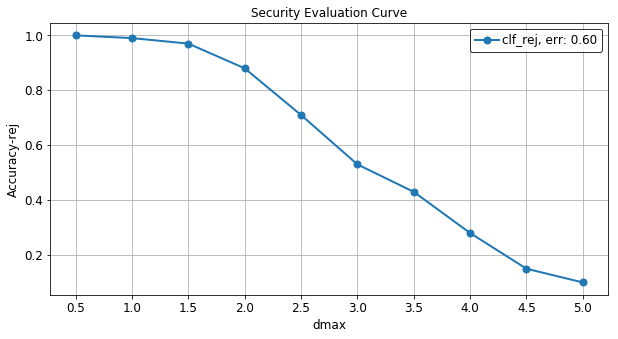

In [159]:
from secml.figure import CFigure
fig = CFigure(height=5, width=10)

# Convenience function for plotting the Security Evaluation Curve
fig.sp.plot_sec_eval(
    sec_eval.sec_eval_data, metric=CMetricAccuracyReject(),  marker='o', label='clf_rej', show_average=True)

## +++++++++++++
# YOU ARE HERE!
## +++++++++++++

-------

# White-box evaluation

In [160]:
# For simplicity, let's attack a subset of the test set
attack_ds = ts[:100, :]

noise_type = 'l2'  # Type of perturbation 'l1' or 'l2'
dmax = 3.0  # Maximum perturbation
lb, ub = 0., 1.  # Bounds of the attack space. Can be set to `None` for unbounded
y_target = None  # None if `error-generic` or a class label for `error-specific`

# Should be chosen depending on the optimization problem
solver_params = {
    'eta': 0.5,
    'eta_min': 2.0,
    'eta_max': None,
    'max_iter': 100,
    'eps': 1e-6
}

from secml.adv.attacks import CAttackEvasionPGDLS
pgd_ls_attack = CAttackEvasionPGDLS(classifier=clf_rej,
                                    surrogate_classifier=clf_rej,
                                    surrogate_data=tr,
                                    distance=noise_type,
                                    dmax=dmax,
                                    solver_params=solver_params,
                                    y_target=y_target)

In [162]:
print("Attack started...")
eva_y_pred, _, eva_adv_ds, _ = pgd_ls_attack.run(
    attack_ds.X, attack_ds.Y, double_init=True)
print("Attack complete!")

Attack started...
Attack complete!


In [163]:
# Compute predictions on a test set
y_pred = clf_rej.predict(eva_adv_ds.X)

# Evaluate the accuracy of the classifier
acc = metric.performance_score(y_true=eva_adv_ds.Y, y_pred=y_pred)

print("Accuracy on test set: {:.2%}".format(acc))

Accuracy on test set: 17.00%


# Security Evaluation

In [164]:
# Perturbation levels to test
from secml.array import CArray
e_vals = CArray.arange(start=0.5, step=0.5, stop=5.1)

from secml.adv.seceval import CSecEval
sec_eval = CSecEval(
    attack=pgd_ls_attack, param_name='dmax', param_values=e_vals)

# Run the security evaluation using the test set
print("Running security evaluation...")
sec_eval.verbose = 1
sec_eval.run_sec_eval(attack_ds, double_init=False)

Running security evaluation...
2020-04-29 10:21:31,485 - CSecEval.0x7f13ac6328d0 - INFO - Attack with dmax = 0.5
2020-04-29 10:22:22,341 - CSecEval.0x7f13ac6328d0 - INFO - Attack with dmax = 1.0
2020-04-29 10:23:12,384 - CSecEval.0x7f13ac6328d0 - INFO - Attack with dmax = 1.5
2020-04-29 10:24:09,975 - CSecEval.0x7f13ac6328d0 - INFO - Attack with dmax = 2.0
2020-04-29 10:25:16,804 - CSecEval.0x7f13ac6328d0 - INFO - Attack with dmax = 2.5
2020-04-29 10:26:13,095 - CSecEval.0x7f13ac6328d0 - INFO - Attack with dmax = 3.0
2020-04-29 10:27:18,841 - CSecEval.0x7f13ac6328d0 - INFO - Attack with dmax = 3.5
2020-04-29 10:28:20,821 - CSecEval.0x7f13ac6328d0 - INFO - Attack with dmax = 4.0
2020-04-29 10:29:24,045 - CSecEval.0x7f13ac6328d0 - INFO - Attack with dmax = 4.5
2020-04-29 10:30:34,335 - CSecEval.0x7f13ac6328d0 - INFO - Attack with dmax = 5.0


In [165]:
%matplotlib inline

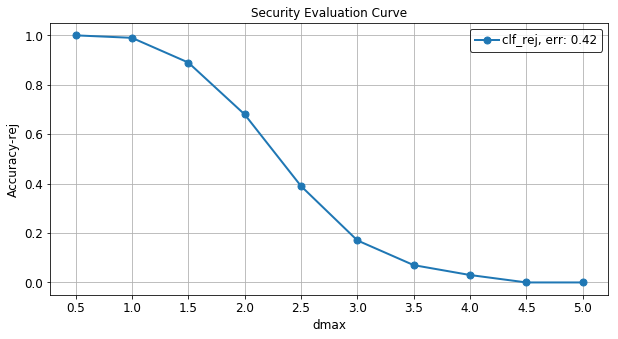

In [166]:
from secml.figure import CFigure
fig = CFigure(height=5, width=10)

# Convenience function for plotting the Security Evaluation Curve
fig.sp.plot_sec_eval(
    sec_eval.sec_eval_data, metric=CMetricAccuracyReject(),  marker='o', label='clf_rej', show_average=True)

Compute reject percentage

In [167]:
rej_percentage = [(p == -1).sum()/p.shape[0] for p in sec_eval.sec_eval_data.Y_pred]
rej_percentage

[0.19, 0.44, 0.58, 0.56, 0.32, 0.15, 0.07, 0.03, 0.0, 0.0]

Text(0.5, 1.0, '% Reject')

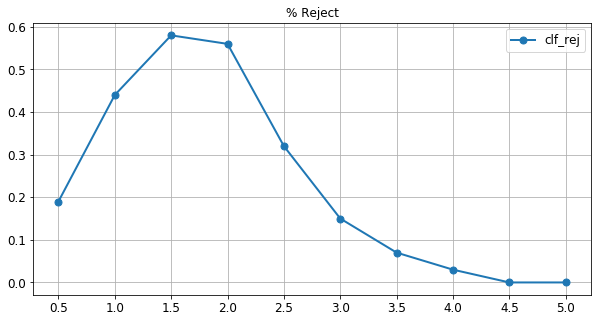

In [168]:
fig = CFigure(height=5, width=10)

fig.sp.plot(e_vals, y=rej_percentage, marker='o', label='clf_rej')
fig.sp.xticks(e_vals)
fig.sp.legend()
fig.sp.grid()
fig.sp.title("% Reject")

----

# Test against multiple attacks

Using `cleverhans` wrapper for multiple-attacks implementation

In [169]:
from cleverhans.attacks import CarliniWagnerL2, ProjectedGradientDescent, \
    MomentumIterativeMethod,FastGradientMethod

In [170]:
dmax = 3.0  # Maximum perturbation
lb, ub = 0., 1.  # Bounds of the attack space. Can be set to `None` for unbounded
y_target = None  # None if `error-generic` or a class label for `error-specific`

In [171]:
e_vals = CArray.arange(start=0., step=0.1, stop=1.1)

In [172]:
from collections import namedtuple
Attack = namedtuple('Attack', 'attack_cls short_name attack_params')

attacks = [
    Attack(FastGradientMethod, 'FGM', {'eps': dmax,
                                       'clip_max': ub,
                                       'clip_min': lb,
                                       'ord': 2}),
    Attack(ProjectedGradientDescent, 'PGD', {'eps': dmax,
                                             'eps_iter': 0.05,
                                             'nb_iter': 50,
                                             'clip_max': ub,
                                             'clip_min': lb,
                                             'ord': 2,
                                             'rand_init': False}),
    Attack(MomentumIterativeMethod, 'MIM', {'eps': dmax,
                                            'eps_iter': 0.05,
                                            'nb_iter': 50,
                                            'clip_max': ub,
                                            'clip_min': lb,
                                            'ord': 2,
                                            'decay_factor': 1}),
    Attack(CarliniWagnerL2, 'CW2', {'binary_search_steps': 1,
                                    'initial_const': 0.2,
                                    'confidence': 10,
                                    'abort_early': True,
                                    'clip_min': lb,
                                    'clip_max': ub,
                                    'max_iterations': 50,
                                    'learning_rate': 0.1})
]

Running attacks and compute evaluation curves

In [173]:
attack_ds = ts[:100, :]
attack_ds

CDataset{'X': CArray(100, 784)(dense: [[0. 0. 0. ... 0. 0. 0.] [0. 0. 0. ... 0. 0. 0.] [0. 0. 0. ... 0. 0. 0.] ... [0. 0. 0. ... 0. 0. 0.] [0. 0. 0. ... 0. 0. 0.] [0. 0. 0. ... 0. 0. 0.]]), 'Y': CArray(100,)(dense: [7 2 1 ... 7 6 9]), 'header': CDatasetHeader{'num_samples': None, 'img_w': 28, 'img_h': 28, 'y_original': (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)}}

In [174]:
sec_eval_bkp = []

In [ ]:
from secml.adv.attacks import CAttackEvasionCleverhans
from secml.adv.seceval import CSecEval
from secml.figure import CFigure
%matplotlib inline

fig = CFigure(5, 10)
for i, attack in enumerate(attacks):
    
    # Instantiate `cleverhans_attack`
    cleverhans_attack = CAttackEvasionCleverhans(
            classifier=dnn,
            surrogate_classifier=dnn,
            surrogate_data=tr,
            y_target=y_target,
            clvh_attack_class=attack.attack_cls,
            **attack.attack_params)
    
    # Run sec_eval
    sec_eval = CSecEval(attack=cleverhans_attack, param_name='dmax', param_values=e_vals)
    # Run the security evaluation using the test set
    print("Running security evaluation for {} attack".format(attack.short_name))
    sec_eval.verbose = 1
    sec_eval.run_sec_eval(attack_ds)#, double_init=False)
    
    # Save a backup
    sec_eval_bkp.append(sec_eval)
    
    # Plot
    fig.sp.plot_sec_eval(sec_eval.sec_eval_data, marker='o', label=attack.short_name, show_average=True)

fig.show()

In [ ]:
import numpy as np

In [ ]:
dmax = 0.

In [ ]:
attack_cls = FastGradientMethod
attack_params = {'eps': dmax,
                 'clip_max': ub,
                 'clip_min': lb,
                 'ord': np.inf}

In [ ]:
cleverhans_attack = CAttackEvasionCleverhans(
            classifier=dnn,
            surrogate_classifier=dnn,
            surrogate_data=tr,
            y_target=y_target,
            clvh_attack_class=attack_cls,
            **attack_params)

In [ ]:
print("Attack started...")
eva_y_pred, _, eva_adv_ds, _ = cleverhans_attack.run(attack_ds.X, attack_ds.Y)
print("Attack complete!")

In [ ]:
from secml.ml.peval.metrics import CMetric
metric = CMetric.create('accuracy')

acc = metric.performance_score(
    y_true=attack_ds.Y, y_pred=dnn.predict(attack_ds.X))
acc_attack = metric.performance_score(
    y_true=attack_ds.Y, y_pred=eva_y_pred)

print("Accuracy on reduced test set before attack: {:.2%}".format(acc))
print("Accuracy on reduced test set after attack: {:.2%}".format(acc_attack))

In [ ]:
e_vals = CArray.arange(start=0., step=0.25, stop=1.1)

In [ ]:
# Run sec_eval
sec_eval = CSecEval(attack=cleverhans_attack, param_name='dmax', param_values=e_vals)
# Run the security evaluation using the test set
print("Running security evaluation for {} attack".format(attack.short_name))
sec_eval.verbose = 1
sec_eval.run_sec_eval(attack_ds)#, double_init=False)

In [ ]:
# Plot
fig = CFigure(5,12)
fig.sp.plot_sec_eval(sec_eval.sec_eval_data, marker='o', show_average=True)
fig.show()